### **TEAM:** Wissem Boujlida, Majdi Bel Hadj Youssef, Aymen Rebhi, Med Ali Moualhi, Amin Bouhamed, Salma Jdidi

### In this lab, we will be exploring how to preprocess unstructured text for building a a conceptual graph based recommendation system. <br>Text Preprocessing (normalization) is an essential step in natural language processing (NLP) that involves cleaning and transforming unstructured text data to prepare it for your NLP task. It includes tokenization, lemmatization, punctuation and stop-word removal, part-of-speech tagging and corefrence resolution, etc...

# Installing packages

In [1]:
!pip install  PyPDF2
!apt-get install -y poppler-utils
!pip install gdown
!pip install -U layoutparser
!pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.4#egg=detectron2'
!pip install layoutparser[ocr]
!pip install google-api-core google-cloud-vision
!apt-get install tesseract-ocr
!pip install rake-nltk -q
!pip install bertopic
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 6.7 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libpoppler118 poppler-data
Suggested packages:
  ghostscript fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-ukai
  fonts-arphic-uming fonts-nanum
The following NEW packages will be installed:
  libpoppler118 poppler-data poppler-utils
0 upgraded, 3 newly installed, 0 to remove and 74 not upgraded.
Need to get 3430 kB of archives.
After this operation, 17.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 poppler-data all 0.4.11-1 [2171 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libpoppler118 amd64 22.02.0-2ubuntu0.2 [1074 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.2 

# Necessary imports

In [2]:
import PyPDF2
from pdf2image import convert_from_path
import os
import gdown
import layoutparser as lp
import cv2
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.tokenize import sent_tokenize
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from bertopic import BERTopic
from rake_nltk import Rake
from transformers import pipeline
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, pipeline
import re
import string

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/opt/conda/lib/python3.10/site-packages/uma

# Extracting chapter 11 of PMBOK [430-494] 

In [3]:
!mkdir data

In [4]:
def extract_pdf_pages(pdf_file, output_file, page_numbers):
    pdf_reader = PyPDF2.PdfReader(pdf_file)
    output_pdf_file = PyPDF2.PdfWriter()
    for page_number in page_numbers:
        page = pdf_reader.pages[page_number]
        output_pdf_file.add_page(page)
    with open(output_file, "wb") as f:
        output_pdf_file.write(f)

In [5]:
pdf_file = "/kaggle/input/pmbok-pdf/PMBOK6-2017.pdf"
output_file = "data/project_risk_management.pdf"
page_numbers = range(430, 494)

extract_pdf_pages(pdf_file, output_file, page_numbers)

# Convert PDF pages to images

In [6]:
def convert_pdf_to_img(pdf_file):
    return convert_from_path(pdf_file)

In [7]:
pdf_file = "data/project_risk_management.pdf"

images = convert_pdf_to_img(pdf_file)

In [8]:
!mkdir data/images

In [9]:
images_dataset_path = "data/images"

In [10]:
for i in range(len(images)):
    images[i].save(os.path.join(images_dataset_path, 'page'+ str(i) +'.jpg'), 'JPEG')

# Extracting titles, text, figures and tables using LayoutParser

### Downloading custom LayoutParser Model (trained on PMBOK&PMI using transfer learning) from Google drive

In [11]:
!mkdir data/models

In [12]:
url = 'https://drive.google.com/uc?id=1AOCfRrwaibob-Cjl4yI4tqqbheP2L2BH' 
output = 'data/models/layoutparser_model.zip'

gdown.download(url, output)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1AOCfRrwaibob-Cjl4yI4tqqbheP2L2BH
From (redirected): https://drive.google.com/uc?id=1AOCfRrwaibob-Cjl4yI4tqqbheP2L2BH&confirm=t&uuid=068e00b5-9d3e-430c-b97e-216038b7a085
To: /kaggle/working/data/models/layoutparser_model.zip
100%|██████████| 2.15G/2.15G [00:26<00:00, 81.4MB/s]


'data/models/layoutparser_model.zip'

In [13]:
!mkdir data/models/layoutparser_model

In [14]:
!unzip data/models/layoutparser_model.zip -d data/models/layoutparser_model

Archive:  data/models/layoutparser_model.zip
   creating: data/models/layoutparser_model/kaggle/working/layout-model-training/outputs/prima/fast_rcnn_R_50_FPN_3x/
  inflating: data/models/layoutparser_model/kaggle/working/layout-model-training/outputs/prima/fast_rcnn_R_50_FPN_3x/model_final.pth  
  inflating: data/models/layoutparser_model/kaggle/working/layout-model-training/outputs/prima/fast_rcnn_R_50_FPN_3x/log.txt  
  inflating: data/models/layoutparser_model/kaggle/working/layout-model-training/outputs/prima/fast_rcnn_R_50_FPN_3x/eval.csv  
  inflating: data/models/layoutparser_model/kaggle/working/layout-model-training/outputs/prima/fast_rcnn_R_50_FPN_3x/model_0000199.pth  
  inflating: data/models/layoutparser_model/kaggle/working/layout-model-training/outputs/prima/fast_rcnn_R_50_FPN_3x/config.yaml  
  inflating: data/models/layoutparser_model/kaggle/working/layout-model-training/outputs/prima/fast_rcnn_R_50_FPN_3x/model_0001999.pth  
  inflating: data/models/layoutparser_mode

In [15]:
!rm data/models/layoutparser_model.zip

In [16]:
layoutparser_model_config_path = "data/models/layoutparser_model/kaggle/working/layout-model-training/outputs/prima/fast_rcnn_R_50_FPN_3x/config.yaml" 
layoutparser_model_path = "data/models/layoutparser_model/kaggle/working/layout-model-training/outputs/prima/fast_rcnn_R_50_FPN_3x/model_final.pth"

layoutparser_model = lp.Detectron2LayoutModel(
    config_path = layoutparser_model_config_path,
    model_path = layoutparser_model_path,
    extra_config = ["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.75,], # <-- Only output high accuracy preds
    label_map={0: "figure", 1: "table", 2: "text", 3:"title"}
)

### Testing the custom layoutparser model on a random page from the PMBOK

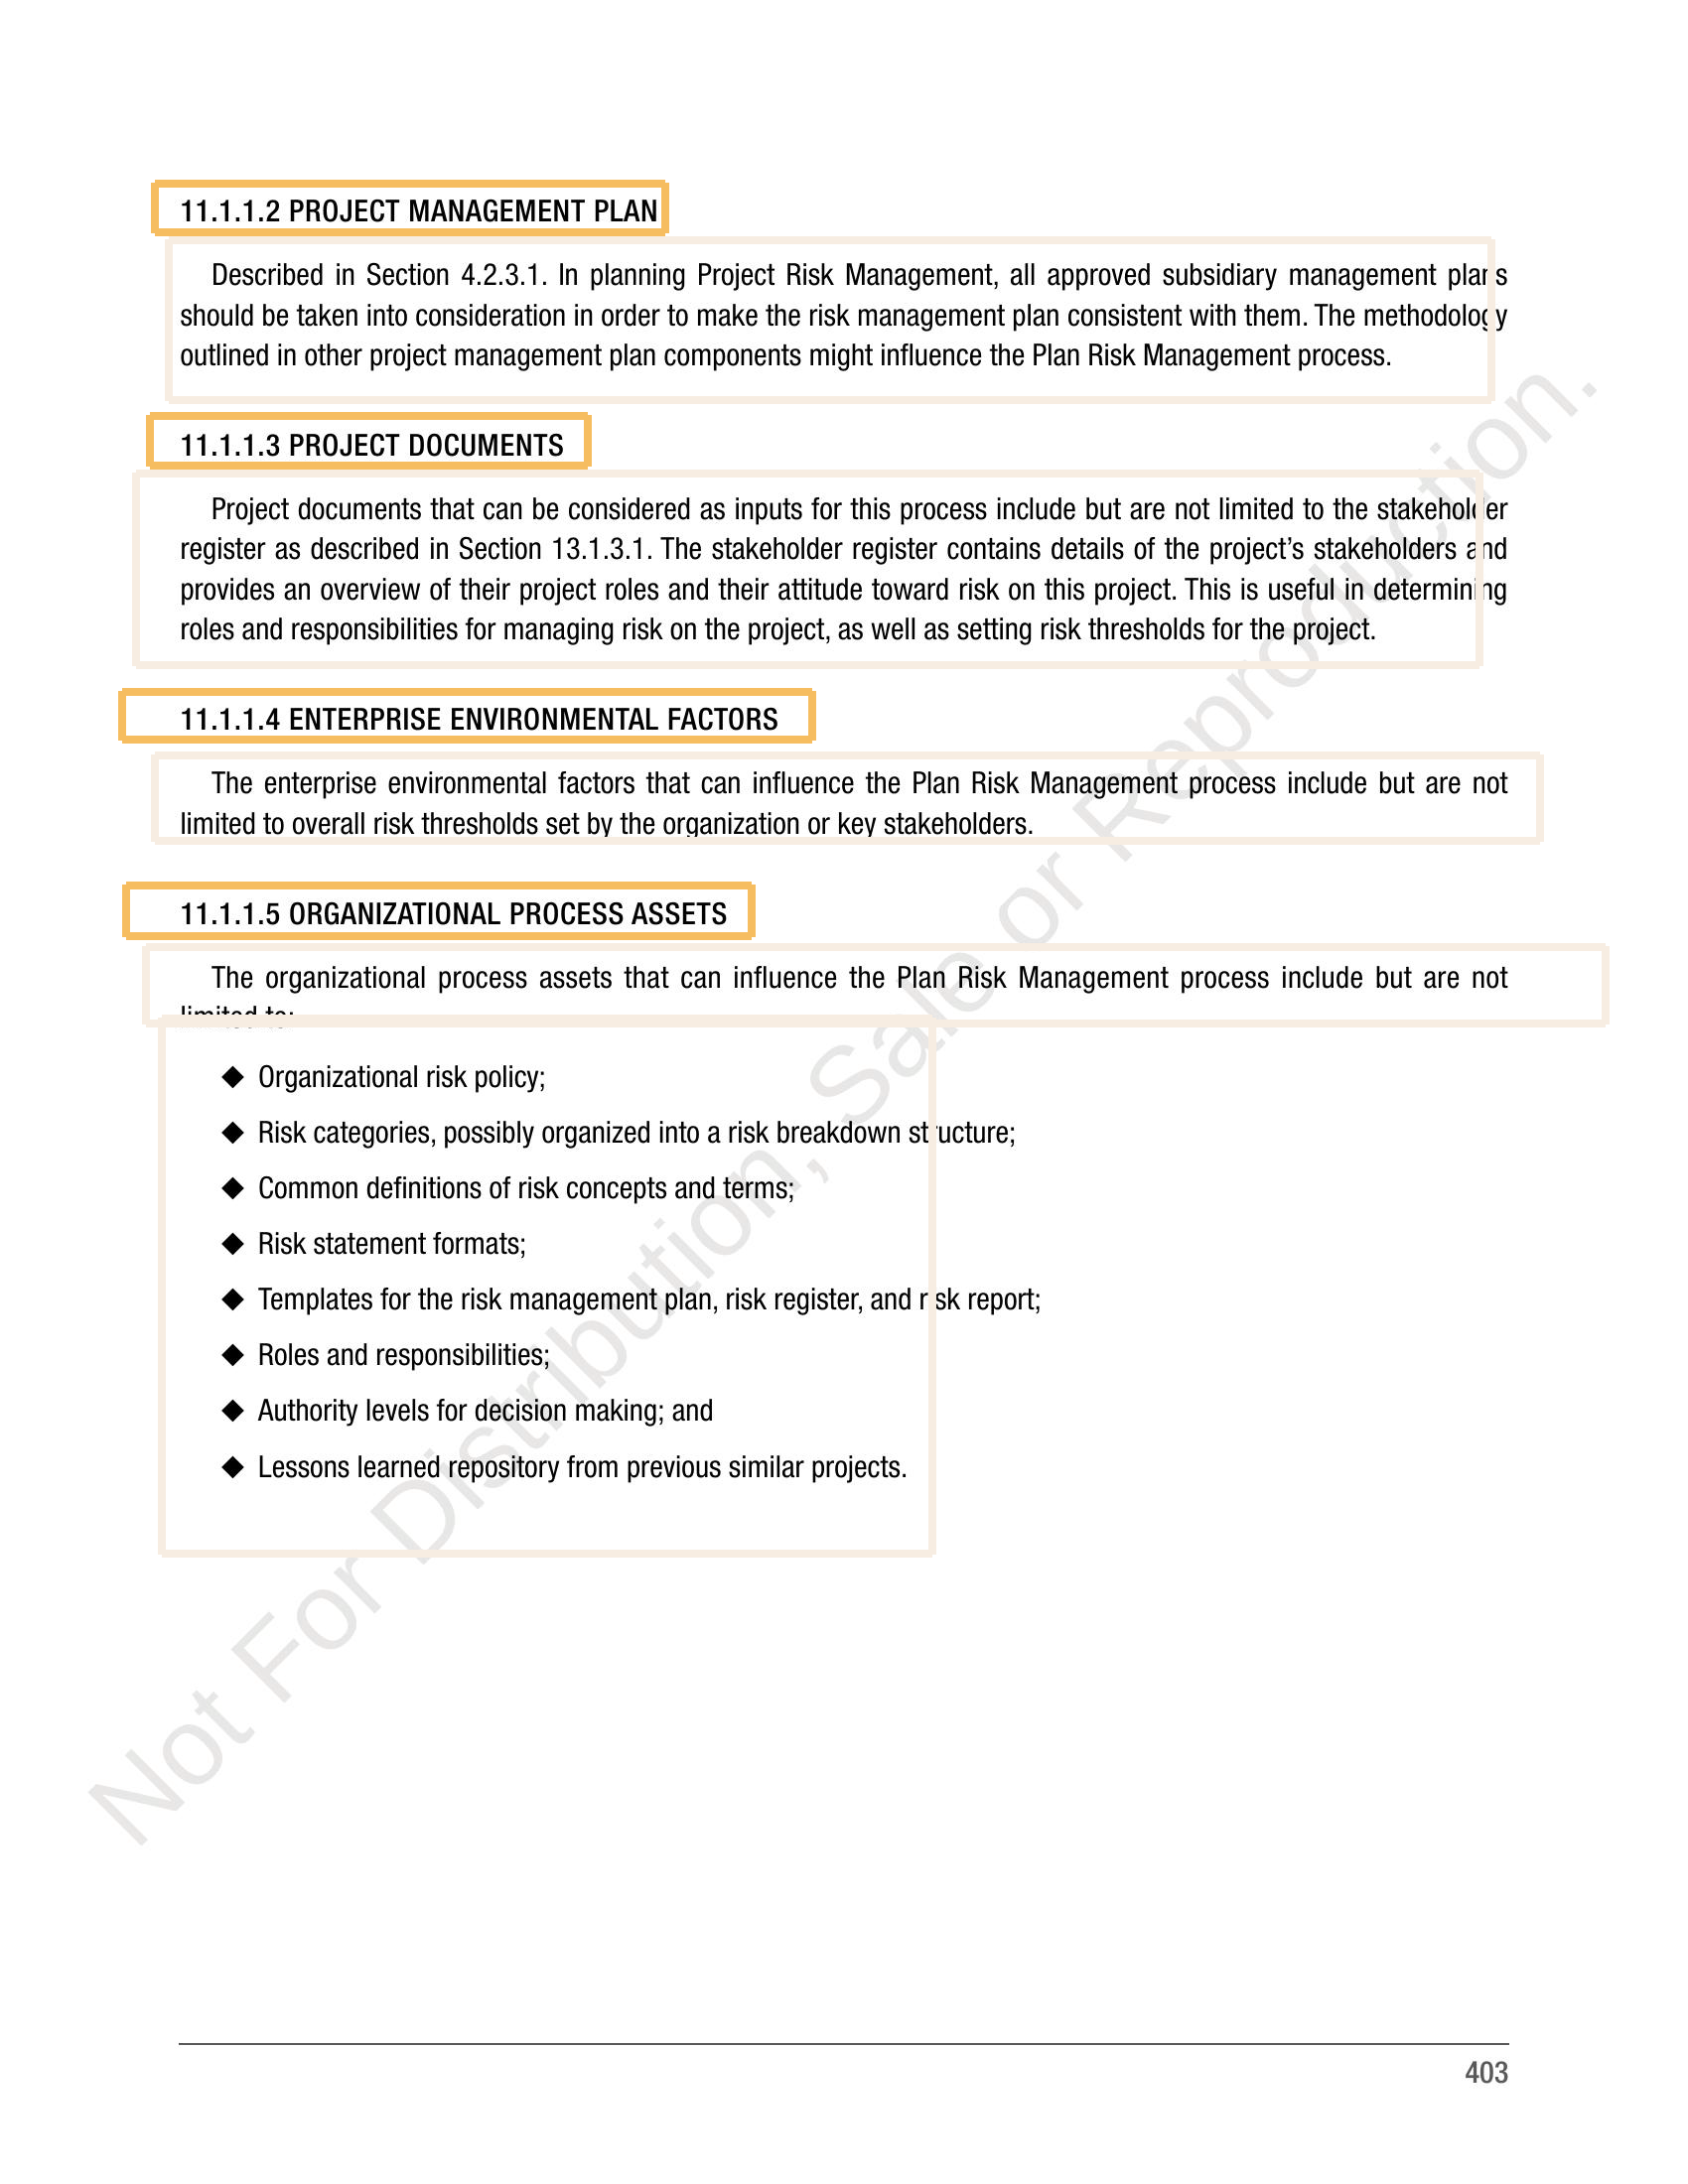

In [17]:
i = 8
img_path = os.path.join(images_dataset_path, "page"+ str(i) +'.jpg')
img = cv2.imread(img_path)
img_layout = layoutparser_model.detect(img)
lp.draw_box(img, img_layout,)

In [18]:
# Use the coordinate system to sort the layout blocks
img_layout.sort(key = lambda block: block.coordinates[1], inplace=True)

In [19]:
ocr_agent = lp.TesseractAgent(languages='eng')

In [20]:
# Extract text from layout blocks
extracted_text = []
for block in img_layout:
    if(block.type=="title"):
        img_segment = (block.pad(left=5, right=5, top=5, bottom=5).crop_image(img))
        title_text = ocr_agent.detect(img_segment)
        extracted_text.append('<title>')
        extracted_text.append(title_text)
        extracted_text.append('</title>')
    elif(block.type=="text"):
        img_segment = (block.pad(left=5, right=5, top=5, bottom=5).crop_image(img))
        text_text = ocr_agent.detect(img_segment)
        extracted_text.append(text_text)

In [21]:
print(''.join(extracted_text))

<title>11.1.1.2 PROJECT MANAGEMENT PLAN
</title>Described in Section 4.2.3.1. In planning Project Risk Management, all approved subsidiary management plan
should be taken into consideration in order to make the risk management plan consistent with them. The methodolog
outlined in other project management plan components might influence the Plan Risk Management process.
<title>11.1.1.3 PROJECT DOCUMENTS
</title>Project documents that can be considered as inputs for this process include but are not limited to the stakehold
register as described in Section 13.1.3.1. The stakeholder register contains details of the project’s stakeholders ai
provides an overview of their project roles and their attitude toward risk on this project. This is useful in determini
roles and responsibilities for managing risk on the project, as well as setting risk thresholds for the project.
<title>11.1.1.4 ENTERPRISE ENVIRONMENTAL FACTORS
</title>The enterprise environmental factors that can influence the 

In [22]:
title_text_blocks = []
for title_text_block in ''.join(extracted_text).split('<title>'):
    if title_text_block != '':
        title = title_text_block[:title_text_block.index('</title>')]
        text = title_text_block[title_text_block.index('</title>')+len("</title>"):]
        title_text_blocks.append((title, text))

In [23]:
pd.DataFrame(title_text_blocks, columns = ['title', 'text']).head()

,title,text
0,11.1.1.2 PROJECT MANAGEMENT PLAN\n,Described in Section 4.2.3.1. In planning Proj...
1,11.1.1.3 PROJECT DOCUMENTS\n,Project documents that can be considered as in...
2,11.1.1.4 ENTERPRISE ENVIRONMENTAL FACTORS\n,The enterprise environmental factors that can ...
3,11.1.1.5 ORGANIZATIONAL PROCESS ASSETS\n,The organizational process assets that can inf...


### Extracting titles, text using LayoutParser from PMBOK

In [25]:
title_text_blocks = []
for img_name in sorted(os.listdir(images_dataset_path), key=lambda img_name: int(img_name.split(".")[0][4:])):
    img_path = os.path.join(images_dataset_path, img_name)
    img = cv2.imread(img_path)
    img_layout = layoutparser_model.detect(img)
    img_layout.sort(key = lambda block: block.coordinates[1], inplace=True)
    
    extracted_text = []
    for block in img_layout:
        if(block.type=="title"):
            img_segment = (block.pad(left=5, right=5, top=5, bottom=5).crop_image(img))
            title = ocr_agent.detect(img_segment) # Text extraction using ocr
            extracted_text.append('<title>')
            extracted_text.append(title)
            extracted_text.append('</title>')
        elif(block.type=="text"):
            img_segment = (block.pad(left=5, right=5, top=5, bottom=5).crop_image(img)) # crop block image  
            text = ocr_agent.detect(img_segment) # Text extraction using ocr
            extracted_text.append(text)
    
    for title_text_block in ''.join(extracted_text).split('<title>'):
        if title_text_block != '':
            try:
                title = title_text_block[:title_text_block.index('</title>')]
                text = title_text_block[title_text_block.index('</title>')+len("</title>"):]
                title_text_blocks.append((title.lower(), text.lower()))  
            except ValueError:
                title_text_blocks[-1] = (title_text_blocks[-1][0], title_text_blocks[-1][1]+title_text_block)   

In [26]:
data = pd.DataFrame(title_text_blocks, columns = ['title', 'text'])

In [27]:
data.head()

,title,text
0,project risk management\n,project risk management includes the processes...
1,key concepts for project risk management\n,all projects are risky since they are unique u...
2,trends and emerging practices in project risk ...,the focus of project risk management is broade...
3,tailoring considerations\n,"because each project is unique, it is necessar..."
4,considerations for agile/adaptive environments\n,"high-variability environments, by definition, ..."


# Text cleaning

The extracted text may contain special characters or layout artifacts. It may be necessary to clean up the text by removing these unwanted characters.

In [28]:
def clean_text(txt):
    clean_txt = re.sub('[@#$\x00-\x08\x0b\x0c\x0e-\x1f\x7f-\xff\n]', '', txt)
    return clean_txt

# Remove punctuations

Punctuation marks are marks indicating how a text should be read and, consequently, understood. But whether punctuation marks should be omitted or retained, it is totally up to the NLP task you're performing and the context.

In [ ]:
def remove_punctuation(tokens_list):
    tokens_clean = []
    for token in tokens_list: # Go through every token in your tokens list
        if (token not in string.punctuation):  # remove punctuation
            tokens_clean.append(token)
    return tokens_clean

# Part-of-speech tagging (POST)

Part-of-speech tagging (POST), is the process of marking up a word in a text (corpus) to its corresponding part of speech (nouns, verbs, adjectives, adverbs, etc...) based on both its definition and its context. We want the computer to understand the meaning of text correctly and part of that is POST. POST has a lot of applications:

Text modeling
Autocomplete (figure out the next word)
word ambiguity resolution ( Pick a word like watch and figure out if we're talking about it as a noun or as a verb..)
The nltk.tag.AveragedPerceptronTagger is the default tagger as of NLTK version 3.1. This model was trained on on Sections 00-18 of the Wall Street Journal sections of OntoNotes 5. The original implementation comes from Matthew Honnibal, and it outperforms the predecessor maximum entropy POS model in NLTK. You can check this link for the tags set : https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

In [29]:
def POST(tokens_list):
    pos_tags = pos_tag(tokens_list, lang='eng')
    return pos_tags

# Lemmatization

Lemmatization is the process of reducing a word to its most base form, or lemma. This helps in reducing the size of our vocabulary. Unlike stemming, lemmatization reduces words to their base word ensuring that the root word belongs to the language. It’s usually more sophisticated than stemming, since stemmers works on an individual word without knowledge of the context. In the other side lemmatizers uses the linguistic knowledge and the context to derive a properly spelled and grammatically correct base form.<br>
Just like for stemming, there are different lemmatizers. For this example, we’ll use WordNet lemmatizer.<br>
Note that POS tagging can improve lemmatization accuracy. For example, the word ‘leaves’ without a POS tag would get lemmatized to the word ‘leaf’, but with a verb tag, its lemma would become ‘leave’. To get the best results, you’ll have to feed the POS tags to the lemmatizer, or otherwise it might not reduce all the words to the lemmas you desire.

In [30]:
# Define function to lemmatize each token with its POS tag

def lemmatization(tokens_list):
    lemmatizer = WordNetLemmatizer()
    nltk_pos_tags = POST(tokens_list)
    lemmas_list = []
    for nltk_pos_tag in nltk_pos_tags:
        token, pos_tag = nltk_pos_tag
        if pos_tag.startswith('J'):
            lemma = lemmatizer.lemmatize(token, wordnet.ADJ)
            lemmas_list.append(lemma)
        elif pos_tag.startswith('V'):
            lemma = lemmatizer.lemmatize(token, wordnet.VERB)
            lemmas_list.append(lemma)
        elif pos_tag.startswith('N'):
            lemma = lemmatizer.lemmatize(token, wordnet.NOUN)
            lemmas_list.append(lemma)
        elif pos_tag.startswith('R'):
            lemma = lemmatizer.lemmatize(token, wordnet.ADV)
            lemmas_list.append(lemma)
        else:
            lemma = lemmatizer.lemmatize(token)
            lemmas_list.append(lemma)
    return lemmas_list

# Tokenization

Tokenization is the process of breaking down text into individual tokens. a Token could reference a paragraph, a sentence, a word, sub word, or even a character. In this same step, we will also convert each token in the text to lower case.

In [31]:
def word_tokenizer(text):
    tokens_list = word_tokenize(text)
    tokens_list = [token.lower() for token in tokens_list]
    return tokens_list

# Normalizing PMBOK text

In [34]:
def normalize_text(txt):
    clean_txt = clean_text(txt)
    tokens_list = word_tokenizer(clean_txt)
    #tokens_list = remove_punctuation(tokens_list)
    lemmas_list = lemmatization(tokens_list)
    clean_txt = " ".join(lemmas_list)
    return clean_txt

In [35]:
clean_txt_list = []
for text in data.text.values:
    clean_txt = normalize_text(text)
    clean_txt_list.append(clean_txt)

In [36]:
data["clean_text"] = clean_txt_list

In [37]:
data.head()

,title,text,clean_text
0,project risk management\n,project risk management includes the processes...,project risk management include the process of...
1,key concepts for project risk management\n,all projects are risky since they are unique u...,all project be risky since they be unique unde...
2,trends and emerging practices in project risk ...,the focus of project risk management is broade...,the focus of project risk management be broade...
3,tailoring considerations\n,"because each project is unique, it is necessar...","because each project be unique , it be necessa..."
4,considerations for agile/adaptive environments\n,"high-variability environments, by definition, ...","high-variability environment , by definition ,..."


In [38]:
data.to_csv("PMBOK.csv", sep=',', encoding='utf-8')

# Keyword Extraction using Rake

## Testing the rake model on a random paragraph from the PMBOK

In [36]:
rake_model = Rake(punctuations = [')','(',',',':','),',').','.'])

In [37]:
def extract_keywords_using_rake(text, threshold_score):
    rake_model.extract_keywords_from_text(text)
    rake_model.get_ranked_phrases_with_scores()
    keywords_with_scores = rake_model.get_ranked_phrases_with_scores()
    keywords_with_scores = [keyword_with_score for keyword_with_score in rake_model.get_ranked_phrases_with_scores() if keyword_with_score[0]>threshold_score]
    keywords_with_scores = sorted(set(keywords_with_scores), key=lambda keyword_with_score: keyword_with_score[0], reverse=True)
    return keywords_with_scores

In [38]:
extract_keywords_using_rake(text, 4)

[(8.666666666666666, 'risk management plan'),
 (8.666666666666666, 'risk report ;'),
 (4.666666666666666, 'risk register')]

In [39]:
keywords_with_scores_list = []
for text in data.clean_text.values:
    keywords_with_scores = extract_keywords_using_rake(text, 4)
    keywords_with_scores_list.append(keywords_with_scores)

In [40]:
data["keywords"] = keywords_with_scores_list

In [41]:
data.head()

,title,text,clean_text,keywords
0,PROJECT RISK MANAGEMENT\n,Project Risk Management includes the processes...,project risk management include the process of...,"[(78.19565217391303, agreed - upon risk respon..."
1,KEY CONCEPTS FOR PROJECT RISK MANAGEMENT\n,All projects are risky since they are unique u...,all project be risky since they be unique unde...,"[(51.333333333333336, mitigate negative risk t..."
2,TRENDS AND EMERGING PRACTICES IN PROJECT RISK ...,The focus of project risk management is broade...,the focus of project risk management be broade...,"[(63.667080745341615, coordinated approach toe..."
3,TAILORING CONSIDERATIONS\n,"Because each project is unique, it is necessar...",because each project be unique it be necessary...,"[(33.5, produce breakthrough opportunity addre..."
4,CONSIDERATIONS FOR AGILE/ADAPTIVE ENVIRONMENTS\n,"High-variability environments, by definition, ...",high-variability environment by definition inc...,"[(59.66666666666667, cross - functional projec..."


# Entity-Relation Extraction using Rebel

The Rebel model is an autoregressive model that extracts each triplet <subject, predicate, object> present in the input text. The subject and the object represent the two resources being related and the predicate represents the nature of their relationship.To this end, The Rebel model employs BERT-large as the base model.
The Rebel model was developed by Pere-Lluís Huguet Cabot as a part of his PhD study with Babelscape and Sapienza University. The Rebel model is available on [Github](https://github.com/Babelscape/rebel) as well as on [Hugginface](https://huggingface.co/Babelscape/rebel-large), and in the form of spaCy component. The paper of the REBEL model can be found [here](https://github.com/Babelscape/rebel/blob/main/docs/EMNLP_2021_REBEL__Camera_Ready_.pdf).

In [42]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch
import math

In [43]:
# Load the model and the tokenizer
tokenizer = AutoTokenizer.from_pretrained("Babelscape/rebel-large")
model = AutoModelForSeq2SeqLM.from_pretrained("Babelscape/rebel-large")

### Testing REBEL model on random text

In [44]:
def extract_triplets(text):
    triplets = []
    relation, subject, relation, object_ = '', '', '', ''
    text = text.strip()
    current = 'x'
    for token in text.replace("<s>", "").replace("<pad>", "").replace("</s>", "").split():
        if token == "<triplet>":
            current = 't'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
            object_ = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and object_ != '':
        triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
    return triplets

In [45]:
# Text to extract triplets from
text = 'Punta Cana is a resort town in the municipality of Higüey, in La Altagracia Province, the easternmost province of the Dominican Republic.'

In [46]:
# Tokenizer text
model_inputs = tokenizer(text, max_length=256, padding=True, truncation=True, return_tensors = 'pt')

In [47]:
# Generate
gen_kwargs = {
    "max_length": 256,
    "length_penalty": 0,
    "num_beams": 3,
    "num_return_sequences": 3,
}

generated_tokens = model.generate(
    model_inputs["input_ids"].to(model.device),
    attention_mask=model_inputs["attention_mask"].to(model.device),
    **gen_kwargs,
)

In [48]:
# Extract text
decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=False)

In [49]:
decoded_preds

['<s><triplet> Punta Cana <subj> La Altagracia Province <obj> located in the administrative territorial entity <subj> Dominican Republic <obj> country <triplet> Higüey <subj> La Altagracia Province <obj> located in the administrative territorial entity <subj> Dominican Republic <obj> country <triplet> La Altagracia Province <subj> Dominican Republic <obj> country <triplet> Dominican Republic <subj> La Altagracia Province <obj> contains administrative territorial entity</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>',
 '<s><triplet> Punta Cana <subj> La Altagracia Province <obj> located in the administrative territorial entity <triplet> Higüey <subj> La Altagracia Province <obj> located in the administrative territorial entity <subj> Dominican Republic <obj> country <triplet> La Altagracia Province <subj> Dominican Republic <obj> country <triplet> Dominican Republic <subj> La Altagracia Province <obj> contains administrative territorial entity</

In [50]:
# Extract triplets
for idx, sentence in enumerate(decoded_preds):
    print(f'Prediction triplets sentence {idx}')
    print(extract_triplets(sentence))

Prediction triplets sentence 0
[{'head': 'Punta Cana', 'type': 'located in the administrative territorial entity', 'tail': 'La Altagracia Province'}, {'head': 'Punta Cana', 'type': 'country', 'tail': 'Dominican Republic'}, {'head': 'Higüey', 'type': 'located in the administrative territorial entity', 'tail': 'La Altagracia Province'}, {'head': 'Higüey', 'type': 'country', 'tail': 'Dominican Republic'}, {'head': 'La Altagracia Province', 'type': 'country', 'tail': 'Dominican Republic'}, {'head': 'Dominican Republic', 'type': 'contains administrative territorial entity', 'tail': 'La Altagracia Province'}]
Prediction triplets sentence 1
[{'head': 'Punta Cana', 'type': 'located in the administrative territorial entity', 'tail': 'La Altagracia Province'}, {'head': 'Higüey', 'type': 'located in the administrative territorial entity', 'tail': 'La Altagracia Province'}, {'head': 'Higüey', 'type': 'country', 'tail': 'Dominican Republic'}, {'head': 'La Altagracia Province', 'type': 'country', 't

In [51]:
# This Helper Class is used to assist in providing some functionality, which include removing duplicate triplets, extracting triplet from larger texts ..
class KnowledgeBase:
    
    def __init__(self):
        self.triplets = []

    def largeText2KowledgeGraph(self, text, span_length=50):
        model_inputs = tokenizer([text],
                                 max_length=512,
                                 padding=True,
                                 truncation=True,
                                 return_tensors = 'pt')
        # number of tokens in the input text
        num_tokens = len(model_inputs["input_ids"][0])
        
        # Split input text to multiple spans
        num_spans = math.ceil(num_tokens/span_length)
        overlap = math.ceil((num_spans*span_length - num_tokens)/(max(num_spans-1, 1)))
        
        spans_boundaries = []
        start = 0
        for i in range(num_spans):
            spans_boundaries.append([start+span_length*i, start+span_length*(i+1)])
            start -= overlap
        
        tensor_ids = [model_inputs["input_ids"][0][boundary[0]:boundary[1]] for boundary in spans_boundaries]
        tensor_masks = [model_inputs["attention_mask"][0][boundary[0]:boundary[1]] for boundary in spans_boundaries]
        
        model_inputs = {
            "input_ids": torch.stack(tensor_ids),
            "attention_mask": torch.stack(tensor_masks)
          }
        
        num_return_sequences = 3
        
        gen_kwargs = {
            "max_length": 256,
            "length_penalty": 0,
            "num_beams": 3,
            "num_return_sequences": num_return_sequences,}
        
        generated_tokens = model.generate(
            model_inputs["input_ids"].to(model.device),
            attention_mask=model_inputs["attention_mask"].to(model.device),
            **gen_kwargs,)
        
        # Extract text
        decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=False)
        
        i = 0
        
        for sentence_pred in decoded_preds:
            current_span_index = i//num_return_sequences
            triplets = extract_triplets(sentence_pred)
            for triplet in triplets:
                triplet["meta"] = {
                    "spans": [spans_boundaries[current_span_index]]
                }
                self.add_triplet(triplet)
            i += 1
            
    def are_triplets_equal(self, triplet1, triplet2):
        return all(triplet1[attribute] == triplet2[attribute] for attribute in {"head", "type", "tail"})
    
    def does_triplet_exists(self, triplet1):
        return any(self.are_triplets_equal(triplet1, triplet2) for triplet2 in self.triplets)
    
    def merge_triplets(self, triplet1):
        triplet2 = [triplet for triplet in self.triplets if self.are_triplets_equal(triplet1, triplet)]
        spans_to_add = [span for span in triplet1["meta"]["spans"] if span not in triplet2["meta"]["spans"]]
        triplet2["meta"]["spans"] += spans_to_add
        
    def add_triplet(self, triplet):
        if not self.does_triplet_exists(triplet):
            self.triplets.append(triplet)
    
    
    def show_triplets(self):
        print("triplets:")
        for triplet in self.triplets:
            print(f" {triplet}")
    
    def save_triplets_csv(self):
        print("saving triplets to triplets.csv")
        df = pd.DataFrame(self.triplets)
        df.to_csv("triplets.csv", index=False)

In [54]:
triplets_list = []
for text in data.clean_text.values:
    if text != "":
        knowledge_base = KnowledgeBase()
        knowledge_base.largeText2KowledgeGraph(text)
        triplets_list.append(knowledge_base.triplets)
    else:
        triplets_list.append("")

In [55]:
data["triplets"] = triplets_list

In [56]:
data.head()

,title,text,clean_text,keywords,triplets
0,PROJECT RISK MANAGEMENT\n,Project Risk Management includes the processes...,project risk management include the process of...,"[(78.19565217391303, agreed - upon risk respon...","[{'head': 'monitoring risk', 'type': 'subclass..."
1,KEY CONCEPTS FOR PROJECT RISK MANAGEMENT\n,All projects are risky since they are unique u...,all project be risky since they be unique unde...,"[(51.333333333333336, mitigate negative risk t...","[{'head': 'project risk', 'type': 'subclass of..."
2,TRENDS AND EMERGING PRACTICES IN PROJECT RISK ...,The focus of project risk management is broade...,the focus of project risk management be broade...,"[(63.667080745341615, coordinated approach toe...","[{'head': 'non-event risk', 'type': 'subclass ..."
3,TAILORING CONSIDERATIONS\n,"Because each project is unique, it is necessar...",because each project be unique it be necessary...,"[(33.5, produce breakthrough opportunity addre...","[{'head': 'project risk management', 'type': '..."
4,CONSIDERATIONS FOR AGILE/ADAPTIVE ENVIRONMENTS\n,"High-variability environments, by definition, ...",high-variability environment by definition inc...,"[(59.66666666666667, cross - functional projec...","[{'head': 'uncertainty', 'type': 'subclass of'..."


# summarization using bart-large-cnn

In [57]:
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

In [60]:
def text_summarizer(text, summarization_percentage):
    if text != "":
        text_length = len(word_tokenizer(text))
        max_length = int(text_length*summarization_percentage)
        min_length = text_length//2
        summary = summarizer(text, max_length=max_length, min_length=min_length, do_sample=False)
        return summary

In [61]:
summary_list = []
for text in data.clean_text.values:
    summary = text_summarizer(text, 0.65)
    summary_list.append(summary)

In [62]:
data["summary"] = summary_list

In [63]:
data.head()

,title,text,clean_text,keywords,triplets,summary
0,PROJECT RISK MANAGEMENT\n,Project Risk Management includes the processes...,project risk management include the process of...,"[(78.19565217391303, agreed - upon risk respon...","[{'head': 'monitoring risk', 'type': 'subclass...",[{'summary_text': ' project risk management in...
1,KEY CONCEPTS FOR PROJECT RISK MANAGEMENT\n,All projects are risky since they are unique u...,all project be risky since they be unique unde...,"[(51.333333333333336, mitigate negative risk t...","[{'head': 'project risk', 'type': 'subclass of...",[{'summary_text': 'project risk management aim...
2,TRENDS AND EMERGING PRACTICES IN PROJECT RISK ...,The focus of project risk management is broade...,the focus of project risk management be broade...,"[(63.667080745341615, coordinated approach toe...","[{'head': 'non-event risk', 'type': 'subclass ...",[{'summary_text': 'Non-event risk need to be i...
3,TAILORING CONSIDERATIONS\n,"Because each project is unique, it is necessar...",because each project be unique it be necessary...,"[(33.5, produce breakthrough opportunity addre...","[{'head': 'project risk management', 'type': '...",[{'summary_text': 'considerations for tailor i...
4,CONSIDERATIONS FOR AGILE/ADAPTIVE ENVIRONMENTS\n,"High-variability environments, by definition, ...",high-variability environment by definition inc...,"[(59.66666666666667, cross - functional projec...","[{'head': 'uncertainty', 'type': 'subclass of'...",[{'summary_text': ' high-variability environme...


# Generate Definitions using roberta-base-squad2 QA model

In [64]:
model_name = "deepset/roberta-base-squad2"

# Load model & tokenizer
model = AutoModelForQuestionAnswering.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [65]:
nlp = pipeline('question-answering', model=model, tokenizer=tokenizer)

In [66]:
definitions = []
for title, text in zip(data.title.values, data.clean_text.values):
    if text !="":
        QA_input = {
            'question': f'What is the definition of {title}?',
            'context': text
        }
        QA_output = nlp(QA_input)
        definitions.append(QA_output["answer"])
    else:
        definitions.append("")

In [67]:
data["definition"] = definitions

In [68]:
data.head()

,title,text,clean_text,keywords,triplets,summary,definition
0,PROJECT RISK MANAGEMENT\n,Project Risk Management includes the processes...,project risk management include the process of...,"[(78.19565217391303, agreed - upon risk respon...","[{'head': 'monitoring risk', 'type': 'subclass...",[{'summary_text': ' project risk management in...,to increase the probability and/or impact of p...
1,KEY CONCEPTS FOR PROJECT RISK MANAGEMENT\n,All projects are risky since they are unique u...,all project be risky since they be unique unde...,"[(51.333333333333336, mitigate negative risk t...","[{'head': 'project risk', 'type': 'subclass of...",[{'summary_text': 'project risk management aim...,measurable risk threshold
2,TRENDS AND EMERGING PRACTICES IN PROJECT RISK ...,The focus of project risk management is broade...,the focus of project risk management be broade...,"[(63.667080745341615, coordinated approach toe...","[{'head': 'non-event risk', 'type': 'subclass ...",[{'summary_text': 'Non-event risk need to be i...,non-event risk
3,TAILORING CONSIDERATIONS\n,"Because each project is unique, it is necessar...",because each project be unique it be necessary...,"[(33.5, produce breakthrough opportunity addre...","[{'head': 'project risk management', 'type': '...",[{'summary_text': 'considerations for tailor i...,project size
4,CONSIDERATIONS FOR AGILE/ADAPTIVE ENVIRONMENTS\n,"High-variability environments, by definition, ...",high-variability environment by definition inc...,"[(59.66666666666667, cross - functional projec...","[{'head': 'uncertainty', 'type': 'subclass of'...",[{'summary_text': ' high-variability environme...,high-variability environment


In [70]:
data.to_csv("PMBOK.csv", sep=',', encoding='utf-8')